This notebook desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [1]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



In [2]:
data=pd.read_csv('/home/tisinr/MEGA/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [3]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'target'}, inplace=True)
    #change data types
    data['target'] = data['target'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [4]:
data['contact'].value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [5]:
data['poutcome'].value_counts(dropna=False)

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [6]:
data.replace('unknown', pd.NA, inplace=True)

/tmp/ipykernel_53676/341139502.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data.replace('unknown', pd.NA, inplace=True)


In [7]:
data.isnull().sum()

age                   0
job                 288
marital_status        0
education          1857
credit_default        0
balance               0
housing_loan          0
personal_loan         0
contact           13020
day                   0
month                 0
duration              0
campaign              0
pdays                 0
previous              0
poutcome          36959
target                0
dtype: int64

In [46]:
if data.isnull().sum().sum() > 0:
    # Fill missing values with the mode for categorical variables
    data['job'].fillna(data['job'].mode()[0], inplace=True)
    data['marital_status'].fillna(data['marital_status'].mode()[0], inplace=True)
    data['education'].fillna(data['education'].mode()[0], inplace=True)
    data['contact'].fillna(data['contact'].mode()[0], inplace=True)
    data['month'].fillna(data['month'].mode()[0], inplace=True)
    data['day'].fillna(data['day'].mode()[0], inplace=True)
    data['poutcome'].fillna(data['poutcome'].mode()[0], inplace=True)
    data['credit_default'].fillna(data['credit_default'].mode()[0], inplace=True)
    data['housing_loan'].fillna(data['housing_loan'].mode()[0], inplace=True)
    data['personal_loan'].fillna(data['personal_loan'].mode()[0], inplace=True)
else:
    print("No missing values found in the dataset.")


No missing values found in the dataset.


In [8]:
data['contact'].value_counts()/len(data)*100

contact
cellular     64.774059
telephone     6.427639
Name: count, dtype: float64

In [9]:
data.drop(columns=['poutcome','contact'], inplace=True)

Exploratory Data Analysis with Pandas

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             44923 non-null  category
 2   marital_status  45211 non-null  category
 3   education       43354 non-null  category
 4   credit_default  45211 non-null  category
 5   balance         45211 non-null  int64   
 6   housing_loan    45211 non-null  category
 7   personal_loan   45211 non-null  category
 8   day             45211 non-null  category
 9   month           45211 non-null  category
 10  duration        45211 non-null  int64   
 11  campaign        45211 non-null  int64   
 12  pdays           45211 non-null  int64   
 13  previous        45211 non-null  int64   
 14  target          45211 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.5 MB


In [11]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


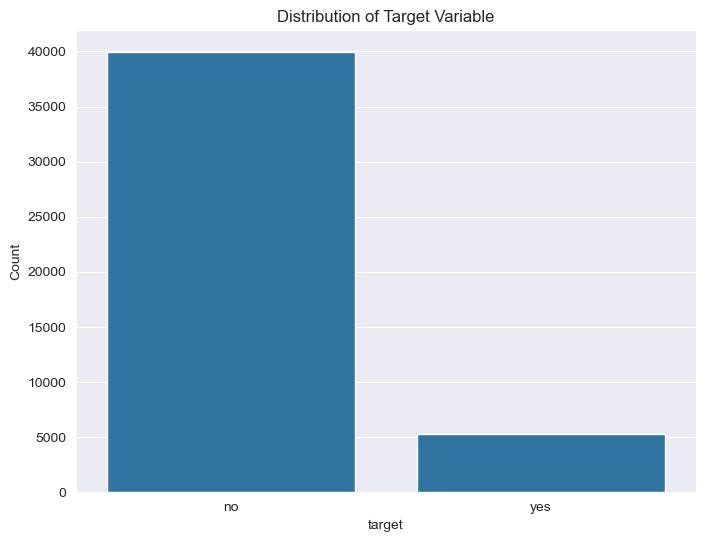

In [12]:
#Distribution plot of target variable
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()



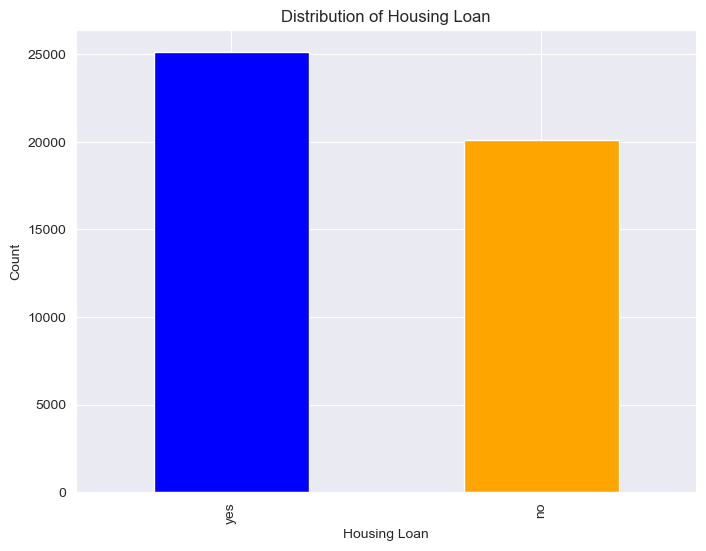

In [13]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar',color=['blue', 'orange'])
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

In [14]:
data['day'].value_counts()

day
20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27    1121
3     1079
26    1035
23     939
22     905
25     840
31     643
10     524
24     447
1      322
Name: count, dtype: int64

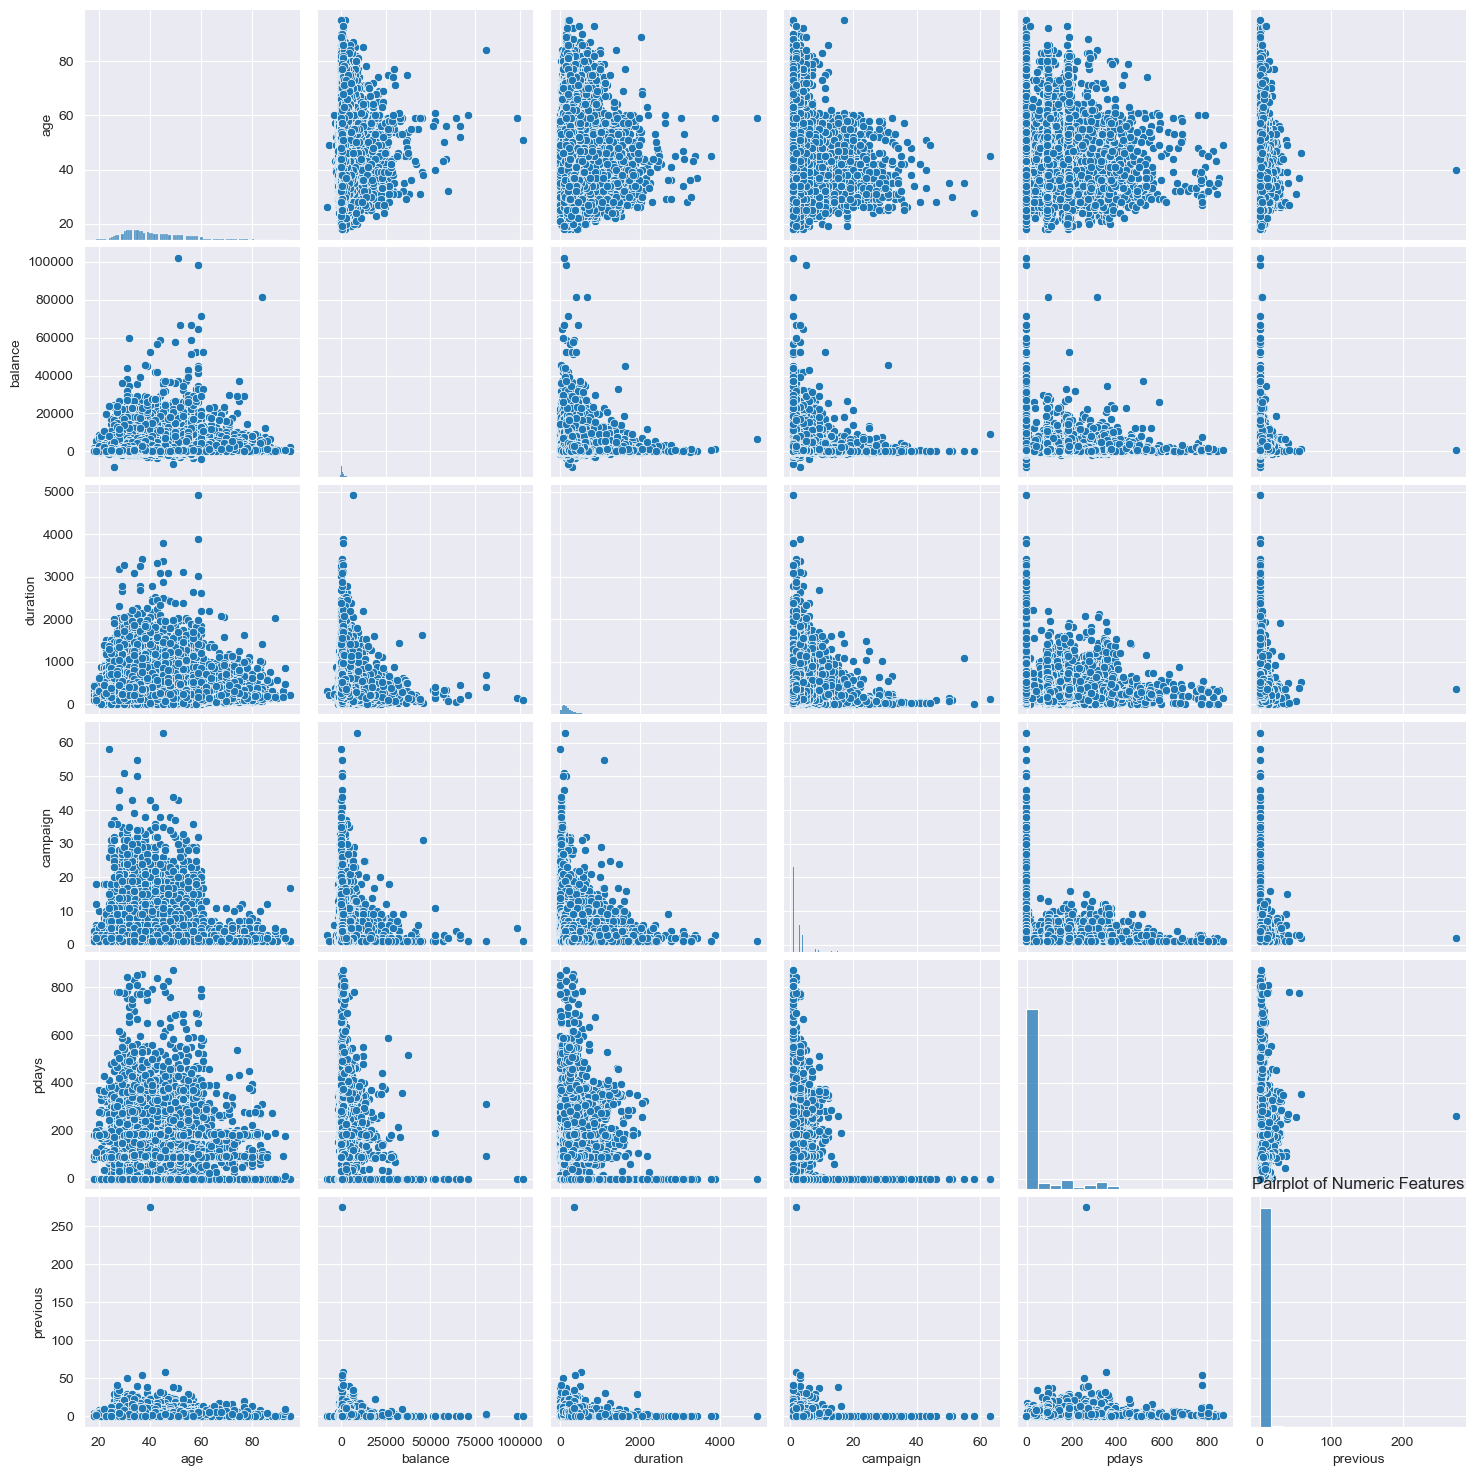

In [15]:
# Distribution plot of numeric features
plt
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
sns.pairplot(numeric_ft)
plt.title('Pairplot of Numeric Features')
plt.show()


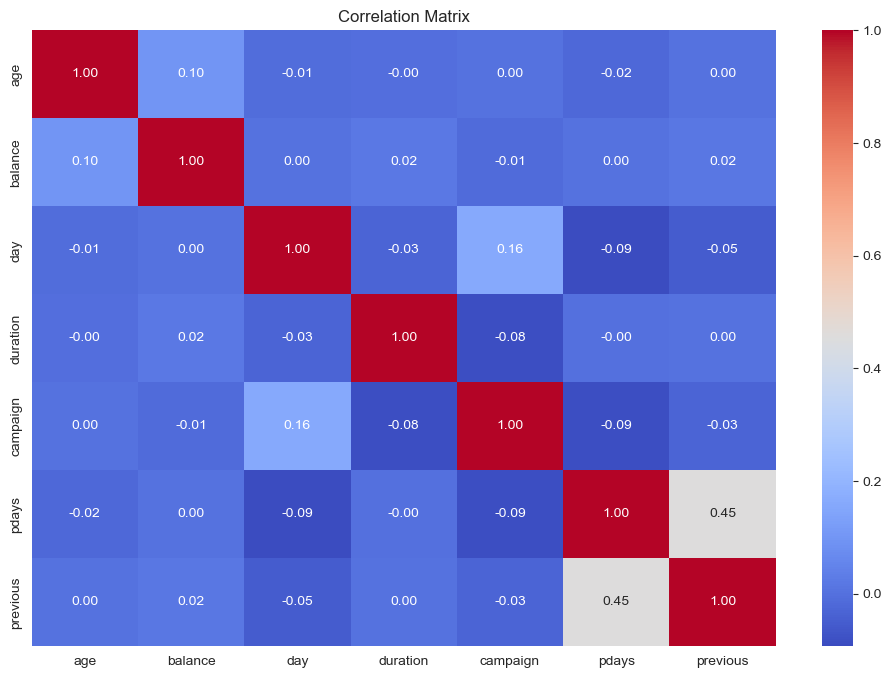

In [16]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_ft.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [17]:
data['job'].fillna(data['job'].mode()[0], inplace=True)
data['education'].fillna(data['education'].mode()[0], inplace=True)

/tmp/ipykernel_53676/1483331465.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['job'].fillna(data['job'].mode()[0], inplace=True)
/tmp/ipykernel_53676/1483331465.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [18]:
data.isnull().sum()

age               0
job               0
marital_status    0
education         0
credit_default    0
balance           0
housing_loan      0
personal_loan     0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
target            0
dtype: int64

In [19]:
data['housing_loan'].value_counts()

housing_loan
yes    25130
no     20081
Name: count, dtype: int64

In [20]:
##category distribution
data['job'].value_counts()/len(data)*100


job
blue-collar      22.162748
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
Name: count, dtype: float64

In [21]:
X=data.drop(columns=['target'])
y=data['target']
print(X.shape)
print(y.shape)

(45211, 14)
(45211,)


In [22]:
data['target'].value_counts()

target
no     39922
yes     5289
Name: count, dtype: int64

Apply Preprocessing to Data

In [23]:
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

In [24]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

In [25]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [26]:
print(y_test.shape)
print(y_train.shape)

(9043,)
(36168,)


In [27]:
y_test.view()

array([0, 1, 0, ..., 0, 0, 0], shape=(9043,))

In [28]:
# Fit preprocessing on training data and transform both sets
X_train_tran = pre_pipeline.fit_transform(X_train)
X_test_tran = pre_pipeline.transform(X_test)  # No fitting on test data!

In [29]:
print(X_train_tran.shape)
print(X_test_tran.shape)


(36168, 42)
(9043, 42)


In [30]:
y_train.shape

(36168,)

Logic Regression with Scikit-learn training steps

In [31]:
#Instantiate and train
logreg=LogisticRegression()
logreg.fit(X_train_tran,y_train)

LogisticRegression()

Logistic Regression
Accuracy:  0.8895278115669578
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.57      0.24      0.34      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043

Confusion Matrix: 
 [[7788  197]
 [ 802  256]]
ROC AUC Score:  0.8845185857698684


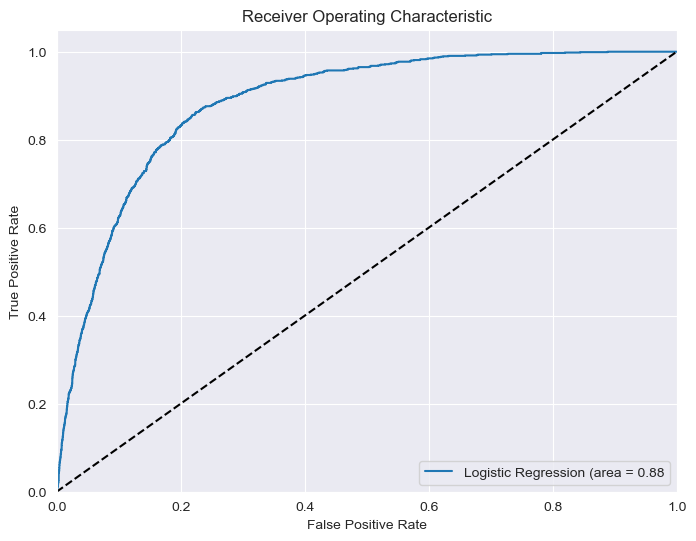

In [32]:
# Predict, Evaluate and plot
y_pred=logreg.predict(X_test_tran)
y_pred_proba=logreg.predict_proba(X_test_tran)[:,1]
print("Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Logistic Regression (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()     

Decision Tree with Scikit-learn training steps

Decision Tree Classifier
Accuracy:  0.8636514431051642
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      7985
           1       0.42      0.43      0.43      1058

    accuracy                           0.86      9043
   macro avg       0.67      0.68      0.67      9043
weighted avg       0.87      0.86      0.86      9043

Confusion Matrix: 
 [[7353  632]
 [ 601  457]]
ROC AUC Score:  0.676399333343592


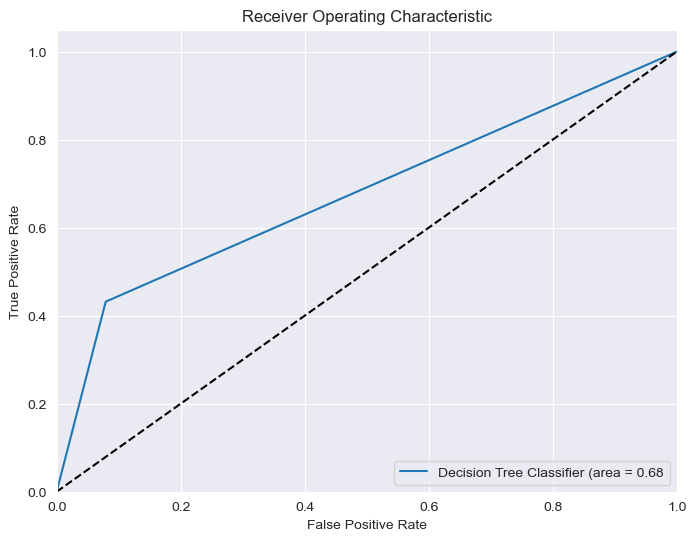

In [33]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train_tran,y_train)
y_pred=dtree.predict(X_test_tran)
y_pred_proba=dtree.predict_proba(X_test_tran)[:,1]
print("Decision Tree Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Decision Tree Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Random Forest with Scikit-learn training steps

Random Forest Classifier
Accuracy:  0.9015813336282207
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.65      0.35      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

Confusion Matrix: 
 [[7780  205]
 [ 685  373]]
ROC AUC Score:  0.9157763315668674


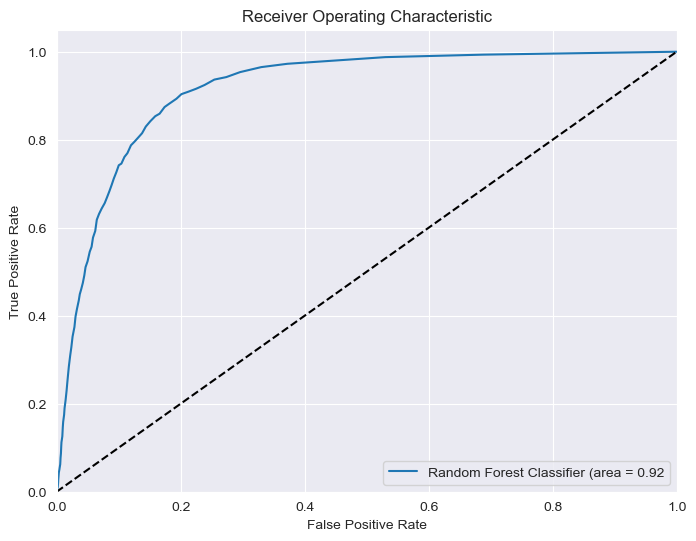

In [34]:
#Random Forest Classifier
rforest=RandomForestClassifier(n_estimators=100)
rforest.fit(X_train_tran,y_train)
y_pred=rforest.predict(X_test_tran)
y_pred_proba=rforest.predict_proba(X_test_tran)[:,1]
print("Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Random Forest Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Gradient Boosting with Scikit-learn training steps

Gradient Boosting Classifier
Accuracy:  0.8946146190423532
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.58      0.34      0.43      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.65      0.69      9043
weighted avg       0.88      0.89      0.88      9043

Confusion Matrix: 
 [[7728  257]
 [ 696  362]]
ROC AUC Score:  0.9128146110441009


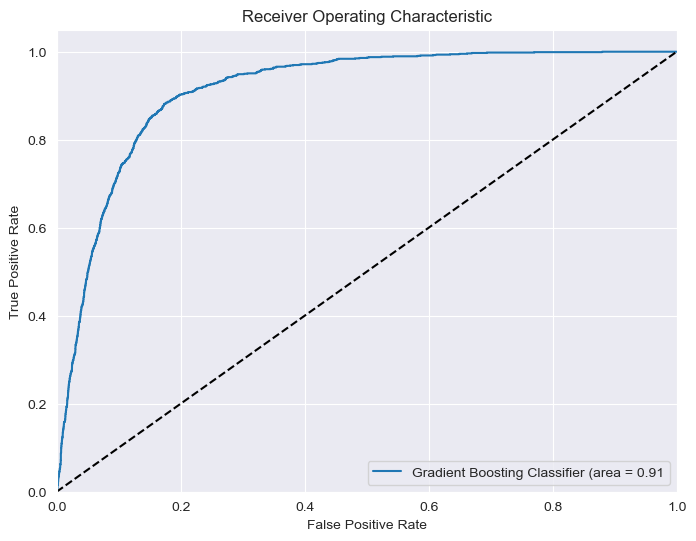

In [35]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train_tran,y_train)
y_pred=gbm.predict(X_test_tran)
y_pred_proba=gbm.predict_proba(X_test_tran)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

SVC with Scikit-learn training steps

Support Vector Classifier
Accuracy:  0.8969368572376424
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.63      0.29      0.40      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043

Confusion Matrix: 
 [[7804  181]
 [ 751  307]]
ROC AUC Score:  0.88268498472443


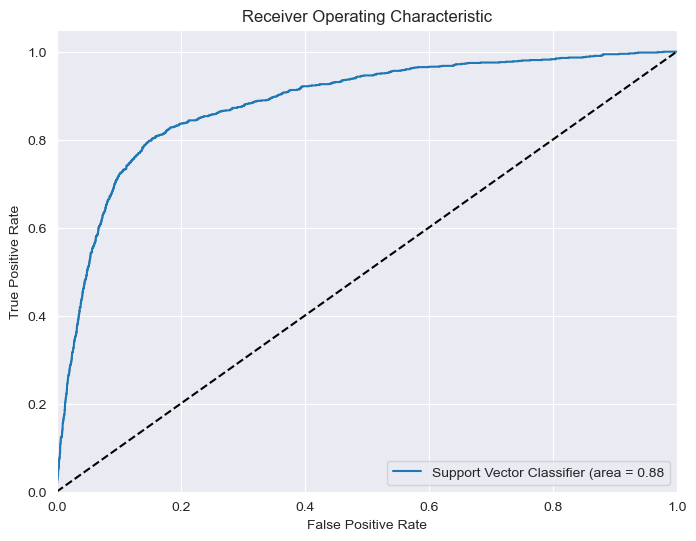

In [36]:
#Support Vector Classifier
svc=SVC(probability=True)
svc.fit(X_train_tran,y_train)
y_pred=svc.predict(X_test_tran)
y_pred_proba=svc.predict_proba(X_test_tran)[:,1]
print("Support Vector Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Support Vector Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

GaussianNB with Scikit-learn training steps

Gaussian Naive Bayes
Accuracy:  0.8532566626119651
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      7985
           1       0.38      0.42      0.40      1058

    accuracy                           0.85      9043
   macro avg       0.65      0.67      0.66      9043
weighted avg       0.86      0.85      0.86      9043

Confusion Matrix: 
 [[7272  713]
 [ 614  444]]
ROC AUC Score:  0.7769899374181033


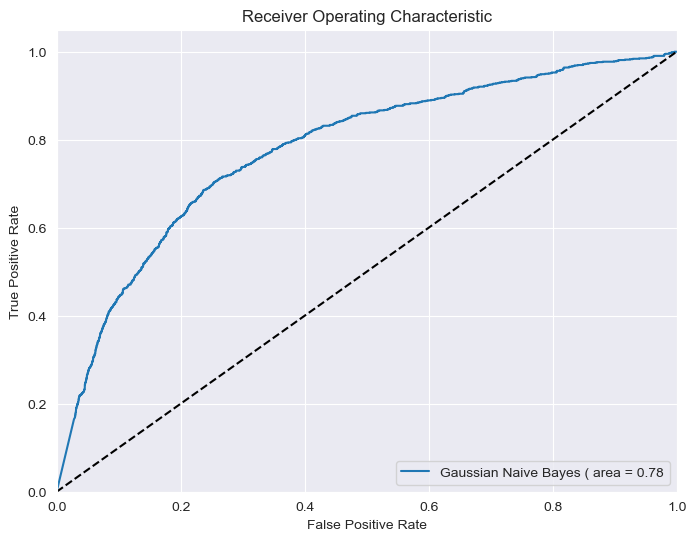

In [37]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train_tran,y_train)
y_pred=gnb.predict(X_test_tran)
y_pred_proba=gnb.predict_proba(X_test_tran)[:,1]
print("Gaussian Naive Bayes")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gaussian Naive Bayes ( area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNeighbors with Scikit-learn training steps

K Neighbors Classifier
Accuracy:  0.8903018909653876
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.56      0.29      0.38      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.63      0.66      9043
weighted avg       0.87      0.89      0.87      9043

Confusion Matrix: 
 [[7742  243]
 [ 749  309]]
ROC AUC Score:  0.8090584543561712


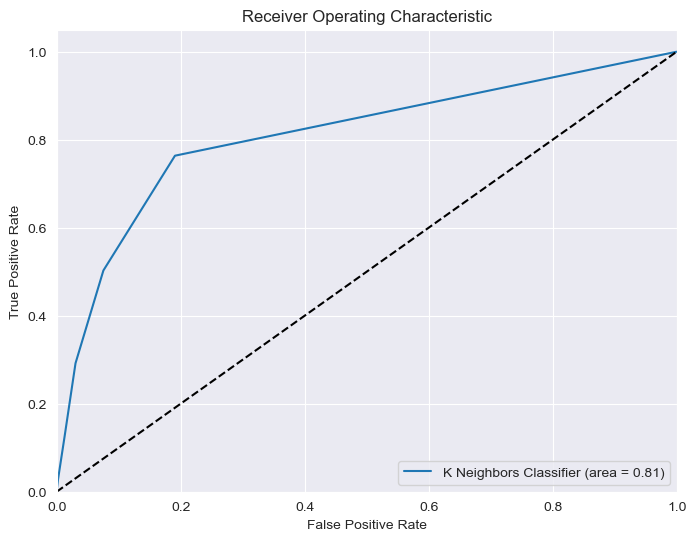

In [38]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train_tran,y_train)
y_pred=knn.predict(X_test_tran)
y_pred_proba=knn.predict_proba(X_test_tran)[:,1]
print("K Neighbors Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='K Neighbors Classifier (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [39]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test_tran)), 
                 accuracy_score(y_test, dtree.predict(X_test_tran)), 
                 accuracy_score(y_test, rforest.predict(X_test_tran)), 
                 accuracy_score(y_test, gbm.predict(X_test_tran)), 
                 accuracy_score(y_test, svc.predict(X_test_tran)), 
                 accuracy_score(y_test, gnb.predict(X_test_tran)), 
                 accuracy_score(y_test, knn.predict(X_test_tran))],
    'ROC AUC Score': [roc_auc_score(y_test, logreg.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test_tran)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test_tran)[:, 1])]
})

In [40]:
# Sort the results by accuracy
results = results.sort_values(by='Accuracy', ascending=False)
# Display the results
print(results)

                  Model  Accuracy  ROC AUC Score
2         Random Forest  0.901581       0.915776
4                   SVC  0.896937       0.882685
3     Gradient Boosting  0.894615       0.912815
6           K Neighbors  0.890302       0.809058
0   Logistic Regression  0.889528       0.884519
1         Decision Tree  0.863651       0.676399
5  Gaussian Naive Bayes  0.853257       0.776990


In [41]:
# Save the model
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dtree, 'dtree_model.pkl')
joblib.dump(rforest, 'rforest_model.pkl')
joblib.dump(gbm, 'gbm_model.pkl')
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(gnb, 'gnb_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(pre_pipeline, 'pre_pipeline.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [42]:
# Load the model
logreg = joblib.load('logreg_model.pkl')
dtree = joblib.load('dtree_model.pkl')
rforest = joblib.load('rforest_model.pkl')
gbm = joblib.load('gbm_model.pkl')
svc = joblib.load('svc_model.pkl')
gnb = joblib.load('gnb_model.pkl')
knn = joblib.load('knn_model.pkl')

In [43]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [44]:
# Preprocess the new data
new_data = pd.DataFrame(pre_processor.transform(new_data), columns=pre_processor.get_feature_names_out())
# Make predictions
logreg_pred = logreg.predict(new_data)
dtree_pred = dtree.predict(new_data)
rforest_pred = rforest.predict(new_data)
gbm_pred = gbm.predict(new_data)
svc_pred = svc.predict(new_data)
gnb_pred = gnb.predict(new_data)
knn_pred = knn.predict(new_data)
# Print the predictions
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("SVC Prediction: ", svc_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("K Neighbors Prediction: ", knn_pred)

Logistic Regression Prediction:  [0]
Decision Tree Prediction:  [1]
Random Forest Prediction:  [0]
Gradient Boosting Prediction:  [0]
SVC Prediction:  [0]
Gaussian Naive Bayes Prediction:  [1]
K Neighbors Prediction:  [1]


/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/tisinr/miniforge3/envs/clasfi/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without 